In [56]:
import pandas as pd
import numpy as np
from datetime import datetime
import itertools
from statistical_functions import preprocess, test_is_I1, test_is_tradable
import matplotlib.pyplot as plt

# Notice
* We haven't consider capital management yet, but it is fairly important.
* Haven't consider unlisted stocks.

# Preprocess

In [4]:
%%time
data = pd.read_csv("ec_data.csv")
data.date = data.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
data['year'] = data.date.apply(lambda x: x.year)
data['month'] = data.date.apply(lambda x: x.month)
data['week'] = data.date.apply(lambda x: x.week)
data['dayofweek'] = data.date.apply(lambda x: x.dayofweek)
data.sort_values('date', inplace=True)
data.head()

Wall time: 56.5 s


In [5]:
data = data[data.year<= 2001]

In [6]:
# create trading time frame
timeframe = data[['year', 'month', 'week']].drop_duplicates()
timeframe.reset_index(drop=True, inplace=True)

# create dataframe of date for available data
# it will be used to check whether stocks containing enough data
# before further cointegration testing
# trade off between speed and more possible pairs
date = pd.DataFrame(data.date.unique(), columns=['date'])
date['year'] = date.date.apply(lambda x: x.year)
date['month'] = date.date.apply(lambda x: x.month)
date['week'] = date.date.apply(lambda x: x.week)
date['dayofweek'] = date.date.apply(lambda x: x.dayofweek)

# Backtest

In [42]:
# initial part
trailing_windows = 52
current_step = trailing_windows
ADF_threshold = -1.9
ASR_threshold = 1.5
top_pairs = 20
max_position_num = 20
stop_loss_sigma_num = 4
take_profit_sigma_num = 0.5
reversion_exit = True
trade_result = pd.DataFrame()

counter = 0

In [47]:
%%time
# trailing part
# prepare data for model
while current_step < len(timeframe):
    timeframe_for_model = timeframe.iloc[current_step-trailing_windows: current_step]

    start_date = date[
        (date.year == timeframe_for_model.iloc[0]['year']) &
        (date.month == timeframe_for_model.iloc[0]['month']) &
        (date.week == timeframe_for_model.iloc[0]['week'])
    ].iloc[0]['date']

    end_date = date[
        (date.year == timeframe_for_model.iloc[-1]['year']) &
        (date.month == timeframe_for_model.iloc[-1]['month']) &
        (date.week == timeframe_for_model.iloc[-1]['week'])
    ].iloc[-1]['date']

    date_for_model = date[(date.date >= start_date) & (date.date<=end_date)]

    data_for_model = data[data.date.isin(date_for_model.date)]

    # prepare data for spread
    timeframe_for_spread = timeframe.iloc[current_step]

    date_for_spread = date[
        (date.year == timeframe_for_spread.year) &
        (date.month == timeframe_for_spread.month) &
        (date.week == timeframe_for_spread.week)
    ]

    data_for_spread = data[
        (data.year == timeframe_for_spread.year) &
        (data.week == timeframe_for_spread.week)
    ]
    data_for_spread = data_for_spread[data_for_spread.date == date_for_spread.date.iloc[0]]

    # find tradable pairs
    possible_pairs = list(map(
        lambda x: list(x),
        list(itertools.combinations(data_for_model.code.unique(), 2))
    ))
    # sort code inside pair to prevent possibility of mis-posistioning
    for pair in possible_pairs:
        pair.sort()

    tradable_pairs = pd.DataFrame()
    for pair in possible_pairs:
        stock_1 = data_for_model[data_for_model.code == pair[0]]
        stock_2 = data_for_model[data_for_model.code == pair[1]]
        if len(stock_1) == len(stock_2) == len(date_for_model):
            temp_pair = test_is_tradable(stock_1.price, stock_2.price)
            if temp_pair is not None:
                # pure list(with two items) can't be assign as index
                temp_pair.index = [tuple(pair)]
                tradable_pairs = pd.concat([tradable_pairs, temp_pair])
        else:
            counter += 1

    # calaulate statistics for tradable pairs
    tradable_pairs['stock_1'] = None
    tradable_pairs['stock_2'] = None

    tradable_pairs[['stock_1', 'stock_2']] = list(map(
        lambda x: [
            data_for_spread[data_for_spread.code == x[0]].price.values[0],
            data_for_spread[data_for_spread.code == x[1]].price.values[0]
        ],
        tradable_pairs.index
    ))

    tradable_pairs[['stock_1_log', 'stock_2_log']] = np.log(
        tradable_pairs[['stock_1', 'stock_2']]
    )           

    tradable_pairs['spread'] = (
        tradable_pairs.stock_2_log - 
        tradable_pairs.intercept -
        tradable_pairs.hedge_ratio*tradable_pairs.stock_1_log
    )

    tradable_pairs['ASR'] = abs(tradable_pairs.spread)/tradable_pairs.sigma

    tradable_pairs['PS'] = np.power(
        tradable_pairs.ASR,
        (ADF_threshold - tradable_pairs.ADF_statistic)
    )

    tradable_pairs['date'] =  date_for_spread.date.iloc[0]

    # criteria of target pairs, select from tradable pairs
    target_pairs = tradable_pairs[tradable_pairs.ASR >= ASR_threshold]
    target_pairs = target_pairs[target_pairs.ADF_statistic < ADF_threshold]
    target_pairs.sort_values('PS', ascending=False, inplace=True)
    target_pairs = target_pairs.iloc[:top_pairs]

    if current_step == trailing_windows:
        open_position = target_pairs
    else:
        # deal for pending stocks, create index for it before dealing for open position
        # in case of re-selecting those stocks which had been closed during this period
        open_position_set = set(open_position.index)
        target_pairs_set = set(target_pairs.index)
        target_pairs_set = target_pairs_set.difference(open_position_set)

        index = list(map(
            lambda x: x in target_pairs_set,
            target_pairs.index
        ))

        pending_target_pairs = target_pairs[index]

        # deal for open position stocks
        for pair in open_position.index:
            position_pair = open_position[open_position.index == pair]
            if pair not in tradable_pairs.index:
                # cointegration_invalid
                tradable_pair = pd.DataFrame(columns=['stock_1_out', 'stock_2_out'],
                                             index=[pair])
                tradable_pair[['stock_1_out', 'stock_2_out']] = list(map(
                    lambda x: [
                        data_for_spread[data_for_spread.code == x[0]].price.values[0],
                        data_for_spread[data_for_spread.code == x[1]].price.values[0]
                    ],
                    [pair]
                ))
                position_pair.columns = position_pair.columns+'_in'
                temp_result = pd.concat([position_pair, tradable_pair], axis=1)
                temp_result['date_out'] = date_for_spread.date.iloc[0]
                temp_result['reason'] = 'cointegration_invalid'
                open_position.drop(index=pair, inplace=True)
                trade_result = pd.concat([trade_result, temp_result])
            else:
                tradable_pair = tradable_pairs[tradable_pairs.index == pair]
                # check whether spread diverge, if diverge then multiplying-term will be <0
                if position_pair.spread.values[0]*tradable_pair.spread.values[0] > 0:
                    if (tradable_pair.ASR > stop_loss_sigma_num).values[0]:
                        # stop loss
                        position_pair.columns = position_pair.columns+'_in'
                        tradable_pair.columns = tradable_pair.columns+'_out'
                        temp_result = pd.concat([position_pair, tradable_pair], axis=1)
                        temp_result['reason'] = 'stop_loss'
                        open_position.drop(index=pair, inplace=True)
                        trade_result = pd.concat([trade_result, temp_result])
                    elif (tradable_pair.ASR <= take_profit_sigma_num).values[0]:
                        # take profit
                        position_pair.columns = position_pair.columns+'_in'
                        tradable_pair.columns = tradable_pair.columns+'_out'
                        temp_result = pd.concat([position_pair, tradable_pair], axis=1)
                        temp_result['reason'] = 'take profit'
                        open_position.drop(index=pair, inplace=True)
                        trade_result = pd.concat([trade_result, temp_result])
                else:
                    #reversion
                    if reversion_exit:
                        position_pair.columns = position_pair.columns+'_in'
                        tradable_pair.columns = tradable_pair.columns+'_out'
                        temp_result = pd.concat([position_pair, tradable_pair], axis=1)
                        temp_result['reason'] = 'reversion'
                        open_position.drop(index=pair, inplace=True)
                        trade_result = pd.concat([trade_result, temp_result])

        if len(open_position) <= max_position_num:
            open_position = pd.concat([
                open_position,
                pending_target_pairs.iloc[:max_position_num-len(open_position)]
            ])
    print("  ", current_step)
    current_step += 1

   52
   53
   54
   55
   56
   57
   58
   59
   60
   61
   62
   63
   64
   65
   66
   67
   68
   69
   70
   71
   72
   73
   74
   75
   76
   77
   78
   79
   80
   81
   82
   83
   84
   85
   86
   87
   88
   89
   90
   91
   92
   93
   94
   95
   96
   97
   98
   99
   100
   101
   102
   103
   104
   105
   106
   107
   108
   109
   110
   111
   112
   113
   114
   115
   116
   117
Wall time: 5min 4s


In [48]:
trade_result.groupby('reason').count()

,ADF_statistic_in,ADF_statistic_out,ASR_in,ASR_out,PS_in,PS_out,date_in,date_out,hedge_ratio_in,hedge_ratio_out,...,spread_in,spread_out,stock_1_in,stock_1_log_in,stock_1_log_out,stock_1_out,stock_2_in,stock_2_log_in,stock_2_log_out,stock_2_out
reason,,,,,,,,,,,,,,,,,,,,,
cointegration_invalid,176,0,176,0,176,0,176,176,176,0,...,176,0,176,176,0,176,176,176,0,176
reversion,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
stop_loss,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
take profit,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56


In [50]:
from datetime import timedelta
((trade_result['date_in'] - trade_result['date_out']) > timedelta(days=0)).sum()

0

In [285]:
trade_result = pd.read_csv('trade_result.csv')

In [286]:
trade_result.reason.unique()

array(['cointegration_invalid', 'take profit', 'reversion', 'stop_loss'], dtype=object)

In [287]:
temp_result = trade_result[trade_result.reason == 'cointegration_invalid']

In [295]:
counter = 0
for i in range(len(temp_result)):
    pair = tuple(list(map(lambda x: int(x), temp_result['Unnamed: 0'].iloc[i][1:11].split(', '))))
    target = date[date.date == temp_result.date_out.iloc[i]]
    
    index = timeframe[
        (timeframe.year == target.year.values[0]) &
        (timeframe.month == target.month.values[0]) & 
        (timeframe.week == target.week.values[0])
    ]
    
    current_step = index.index[0]
    timeframe_for_model = timeframe.iloc[current_step-trailing_windows: current_step]
    
    start_date = date[
        (date.year == timeframe_for_model.iloc[0]['year']) &
        (date.month == timeframe_for_model.iloc[0]['month']) &
        (date.week == timeframe_for_model.iloc[0]['week'])
    ].iloc[0]['date']

    end_date = date[
        (date.year == timeframe_for_model.iloc[-1]['year']) &
        (date.month == timeframe_for_model.iloc[-1]['month']) &
        (date.week == timeframe_for_model.iloc[-1]['week'])
    ].iloc[-1]['date']

    date_for_model = date[(date.date >= start_date) & (date.date<=end_date)]

    data_for_model = data[data.date.isin(date_for_model.date)]

    stock_1 = data_for_model[data_for_model.code == pair[0]]
    stock_2 = data_for_model[data_for_model.code == pair[1]]
    if len(stock_1) == len(stock_2) == len(date_for_model):
        temp_pair = test_is_tradable(stock_1.price, stock_2.price)
        if temp_pair is None:
            print('   no cointergration!')
            counter += 1
        else:
            print('   ok')
    else:
        print('   len not match!', )

   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no cointergration!
   no coin

In [297]:
len(temp_result) == counter

True

In [223]:
pair = (2413, 2431)
target = date[date.date == '2000-11-27']

index = timeframe[
    (timeframe.year == target.year.values[0]) &
    (timeframe.month == target.month.values[0]) & 
    (timeframe.week == target.week.values[0])
]

target

,date,year,month,week,dayofweek
244,2000-11-27,2000,11,48,0


In [224]:
current_step = index.index[0]
timeframe_for_model = timeframe.iloc[current_step-trailing_windows: current_step]
timeframe_for_model.tail(1)

,year,month,week
53,2000,11,47


In [225]:
start_date = date[
    (date.year == timeframe_for_model.iloc[0]['year']) &
    (date.month == timeframe_for_model.iloc[0]['month']) &
    (date.week == timeframe_for_model.iloc[0]['week'])
].iloc[0]['date']

end_date = date[
    (date.year == timeframe_for_model.iloc[-1]['year']) &
    (date.month == timeframe_for_model.iloc[-1]['month']) &
    (date.week == timeframe_for_model.iloc[-1]['week'])
].iloc[-1]['date']

date_for_model = date[(date.date >= start_date) & (date.date<=end_date)]

data_for_model = data[data.date.isin(date_for_model.date)]

stock_1 = data_for_model[data_for_model.code == pair[0]]
stock_2 = data_for_model[data_for_model.code == pair[1]]
if len(stock_1) == len(stock_2) == len(date_for_model):
    temp_pair = test_is_tradable(stock_1.price, stock_2.price)
    if temp_pair is None:
        print('   no cointergration!')
    else:
        print('   ok')
else:
    print('   len not match!', )

   no cointergration!


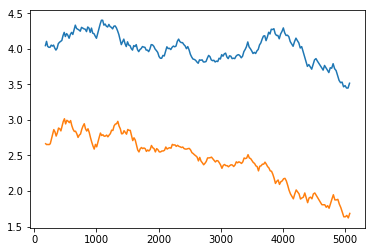

In [226]:
plt.plot(np.log(data_for_model[data_for_model.code == pair[0]].price))
plt.plot(np.log(data_for_model[data_for_model.code == pair[1]].price));

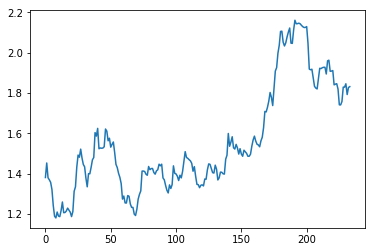

In [227]:
spread = (
    np.log(data_for_model[data_for_model.code == pair[0]].price).values-
    np.log(data_for_model[data_for_model.code == pair[1]].price).values
)
plt.plot(spread);

In [ ]:
%%time
tradable_pairs = pd.DataFrame()
for pair in possible_pairs:
    stock_1 = data_for_model[data_for_model.code == pair[0]]
    stock_2 = data_for_model[data_for_model.code == pair[1]]
    # to ensure stock_1 and, stock_2 are match in date
    stock_1, stock_2 = preprocess(stock_1, stock_2)
    # to avoid "maxlag should be < nobs" error in ADF test
    # also ensure there is enough data for regression
    if len(stock_1) > 200:
        temp_pair = test_is_tradable(stock_1.price, stock_2.price)
        if temp_pair is not None:
            temp_pair.index = [pair]
            tradable_pairs = pd.concat([tradable_pairs, temp_pair])

In [ ]:
%%time
tradable_pairs_2 = pd.DataFrame()
for pair in possible_pairs:
    stock_1 = data_for_model[data_for_model.code == pair[0]]
    stock_2 = data_for_model[data_for_model.code == pair[1]]
    # to ensure stock_1 and, stock_2 are match in date
#     stock_1, stock_2 = preprocess(stock_1, stock_2)
    # to avoid "maxlag should be < nobs" error in ADF test
    # also ensure there is enough data for regression
    if len(stock_1) > 200:
        try:
            temp_pair = test_is_tradable(stock_1.price, stock_2.price)
            if temp_pair is not None:
                temp_pair.index = [pair]
                tradable_pairs_2 = pd.concat([tradable_pairs_2, temp_pair])
        except:
            pass